In [1]:
import os
import numpy as np
import mxnet as mx
import time

from matplotlib import pyplot as plt

from mxnet import autograd, gluon
from mxnet import nd
from mxnet.gluon.data import DataLoader

import gluoncv as gcv
from gluoncv import utils
from gluoncv.utils import viz
from gluoncv.utils import download, viz
from gluoncv.data.transforms import presets
from gluoncv.data import RecordFileDetection
from gluoncv.data.batchify import Tuple, Append
from gluoncv.data.transforms import presets

## Data

In [2]:
# Tweak this values for better result
short, max_size = 512, 1024  # resize image to short side 512 px, but keep maximum length within 1024

train_transform = presets.rcnn.FasterRCNNDefaultTrainTransform(short, max_size)

try:
    ctx = [mx.gpu(0), mx.gpu(1)] # Parallel GPU
    print('GPU Loaded')
except:
    ctx = [mx.cpu()]

classes = ['Waldo'] 

GPU Loaded


### Check if a Dataset is properly loaded

----------- Original Images -----------
image: (980, 1600, 3)
bboxes: (2, 4) class ids: (2, 1)
tensor shape: (3, 512, 836)
box and id shape: (2, 5)


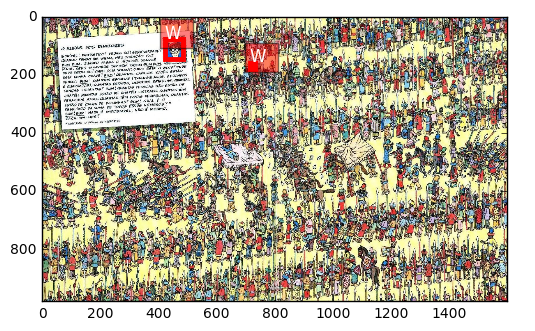

In [3]:
original_train_dataset = gcv.data.RecordFileDetection('./Deep-Waldo/data/train.rec')
combined_train_dataset = gcv.data.RecordFileDetection('./Deep-Waldo/data/combined.rec')


train_image, train_label = original_train_dataset[1]
bboxes = train_label[:, :4]
cids = train_label[:, 4:5]

print('----------- Original Images -----------')
print('image:', train_image.shape)
print('bboxes:', bboxes.shape, 'class ids:', cids.shape)

train_image2, train_label2 = train_transform(train_image, train_label)

print('tensor shape:', train_image2.shape)
print('box and id shape:', train_label2.shape)

ax = viz.plot_bbox(train_image.asnumpy(), bboxes, labels=cids, class_names='Waldo')
plt.show()

----------- Combined Images -----------
image: (500, 413, 3)
bboxes: (1, 4) class ids: (1, 1)
tensor shape: (3, 620, 512)
box and id shape: (1, 5)


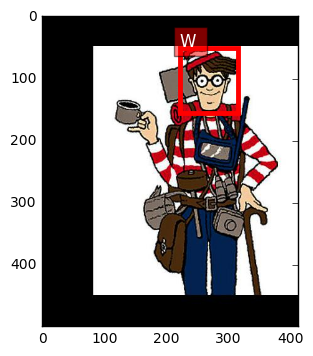

In [4]:
train_image, train_label = combined_train_dataset[150]
bboxes = train_label[:, :4]
cids = train_label[:, 4:5]

print('----------- Combined Images -----------')
print('image:', train_image.shape)
print('bboxes:', bboxes.shape, 'class ids:', cids.shape)

train_image2, train_label2 = train_transform(train_image, train_label)

print('tensor shape:', train_image2.shape)
print('box and id shape:', train_label2.shape)

ax = viz.plot_bbox(train_image.asnumpy(), bboxes, labels=cids, class_names='Waldo')
plt.show()

### Make a Data Loader

In [5]:
batch_size = 8  # for tutorial, we use smaller batch-size
num_workers = 0

# behavior of batchify_fn: stack images, and pad labels
batchify_fn = Tuple(Append(), Append())

original_train_loader = DataLoader(original_train_dataset.transform(train_transform), batch_size, shuffle=True,
                          batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)

combined_train_loader = DataLoader(combined_train_dataset.transform(train_transform), batch_size, shuffle=True,
                          batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)


for ib, batch in enumerate(original_train_loader):
    
    print('Original Train Batch Data with Label')
    print('data 0:', batch[0][0].shape, 'label 0:', batch[1][0].shape)
    print('data 1:', batch[0][1].shape, 'label 1:', batch[1][1].shape)
    
    break
    
for ib, batch in enumerate(combined_train_loader):
    
    print('\nCombined Train Batch Data with Label')
    print('data 0:', batch[0][0].shape, 'label 0:', batch[1][0].shape)
    print('data 1:', batch[0][1].shape, 'label 1:', batch[1][1].shape)
    
    break

Original Train Batch Data with Label
data 0: (1, 3, 512, 697) label 0: (1, 1, 5)
data 1: (1, 3, 512, 779) label 1: (1, 1, 5)

Combined Train Batch Data with Label
data 0: (1, 3, 512, 821) label 0: (1, 1, 5)
data 1: (1, 3, 512, 724) label 1: (1, 1, 5)


## Model

In [6]:
net = gcv.model_zoo.get_model('faster_rcnn_resnet50_v1b_voc', ctx=ctx, pretrained=True)
net.reset_class(classes)
net.collect_params().initialize(force_reinit=True, ctx=ctx)

## Train

### Losses for Training

In [7]:
# the loss to penalize incorrect foreground/background prediction
rpn_cls_loss = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)

# the loss to penalize inaccurate anchor boxes
rpn_box_loss = mx.gluon.loss.HuberLoss(rho=1/9.)  # == smoothl1

# the loss to penalize incorrect classification prediction.
rcnn_cls_loss = mx.gluon.loss.SoftmaxCrossEntropyLoss()

# and finally the loss to penalize inaccurate proposals
rcnn_box_loss = mx.gluon.loss.HuberLoss()  # == smoothl1

In [8]:
# Change this for combined dataset since it has more data

batch_size = 16

original_train_transform = presets.rcnn.FasterRCNNDefaultTrainTransform(short, max_size, net)
combined_train_transform = presets.rcnn.FasterRCNNDefaultTrainTransform(short, max_size, net)

# Return images, labels, rpn_cls_targets, rpn_box_targets, rpn_box_masks loosely

batchify_fn = Tuple(*[Append() for _ in range(5)])
# For the next part, we only use batch size 1

original_train_loader = DataLoader(original_train_dataset.transform(original_train_transform), batch_size, shuffle=True,
                          batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)

combined_train_loader = DataLoader(combined_train_dataset.transform(combined_train_transform), batch_size, shuffle=True,
                          batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)

### Verify Loader

In [9]:
# Check RPN shapes

for ib, batch in enumerate(original_train_loader):
    
    # only check the first batch
    with autograd.train_mode():
        for data, label, rpn_cls_targets, rpn_box_targets, rpn_box_masks in zip(*batch):
            gt_label = label[:, :, 4:5]
            gt_box = label[:, :, :4]
            print('data:', data.shape)
            # box and class labels
            print('box:', gt_box.shape)
            print('label:', gt_label.shape)
            # -1 marks ignored label
            print('rpn cls label:', rpn_cls_targets.shape)
            # mask out ignored box label
            print('rpn box label:', rpn_box_targets.shape)
            print('rpn box mask:', rpn_box_masks.shape)
            
    break
    
# Check RCNN shapes

for ib, batch in enumerate(original_train_loader):
    
    with autograd.train_mode():
        for data, label, rpn_cls_targets, rpn_box_targets, rpn_box_masks in zip(*batch):
            gt_label = label[:, :, 4:5]
            gt_box = label[:, :, :4]
            # network forward
            cls_preds, box_preds, roi, samples, matches, rpn_score, rpn_box, anchors = net(batch[0][0], gt_box)
            # generate targets for rcnn
            cls_targets, box_targets, box_masks = net.target_generator(roi, samples, matches, gt_label, gt_box)

            print('data:', data.shape)
            # box and class labels
            print('box:', gt_box.shape)
            print('label:', gt_label.shape)
            # rcnn does not have ignored label
            print('rcnn cls label:', cls_targets.shape)
            # mask out ignored box label
            print('rcnn box label:', box_targets.shape)
            print('rcnn box mask:', box_masks.shape)
            
    break

data: (1, 3, 545, 512)
box: (1, 1, 4)
label: (1, 1, 1)
rpn cls label: (1, 16800)
rpn box label: (1, 16800, 4)
rpn box mask: (1, 16800, 4)
data: (1, 3, 512, 836)
box: (1, 2, 4)
label: (1, 2, 1)
rpn cls label: (1, 25440)
rpn box label: (1, 25440, 4)
rpn box mask: (1, 25440, 4)
data: (1, 3, 512, 696)
box: (1, 1, 4)
label: (1, 1, 1)
rpn cls label: (1, 21120)
rpn box label: (1, 21120, 4)
rpn box mask: (1, 21120, 4)
data: (1, 3, 512, 512)
box: (1, 1, 4)
label: (1, 1, 1)
rpn cls label: (1, 15360)
rpn box label: (1, 15360, 4)
rpn box mask: (1, 15360, 4)
data: (1, 3, 512, 692)
box: (1, 2, 4)
label: (1, 2, 1)
rpn cls label: (1, 21120)
rpn box label: (1, 21120, 4)
rpn box mask: (1, 21120, 4)
data: (1, 3, 705, 512)
box: (1, 1, 4)
label: (1, 1, 1)
rpn cls label: (1, 21600)
rpn box label: (1, 21600, 4)
rpn box mask: (1, 21600, 4)
data: (1, 3, 512, 759)
box: (1, 2, 4)
label: (1, 2, 1)
rpn cls label: (1, 23040)
rpn box label: (1, 23040, 4)
rpn box mask: (1, 23040, 4)
data: (1, 3, 512, 697)
box: (1, 1,

RuntimeError: Parameter 'resnetv1b_conv0_weight' was not initialized on context cpu(0). It was only initialized on [gpu(0), gpu(1)].

In [ ]:
# Check RPN shapes

for ib, batch in enumerate(combined_train_loader):
    
    # only check the first batch
    with autograd.train_mode():
        
        for data, label, rpn_cls_targets, rpn_box_targets, rpn_box_masks in zip(*batch):
            gt_label = label[:, :, 4:5]
            gt_box = label[:, :, :4]
            print('data:', data.shape)
            # box and class labels
            print('box:', gt_box.shape)
            print('label:', gt_label.shape)
            # -1 marks ignored label
            print('rpn cls label:', rpn_cls_targets.shape)
            # mask out ignored box label
            print('rpn box label:', rpn_box_targets.shape)
            print('rpn box mask:', rpn_box_masks.shape)
            
    break
    
# Check RCNN shapes

for ib, batch in enumerate(combined_train_loader):

    with autograd.train_mode():
        
        for data, label, rpn_cls_targets, rpn_box_targets, rpn_box_masks in zip(*batch):
            gt_label = label[:, :, 4:5]
            gt_box = label[:, :, :4]
            # network forward
            cls_preds, box_preds, roi, samples, matches, rpn_score, rpn_box, anchors = net(batch[0][0], gt_box)
            # generate targets for rcnn
            cls_targets, box_targets, box_masks = net.target_generator(roi, samples, matches, gt_label, gt_box)

            print('data:', data.shape)
            # box and class labels
            print('box:', gt_box.shape)
            print('label:', gt_label.shape)
            # rcnn does not have ignored label
            print('rcnn cls label:', cls_targets.shape)
            # mask out ignored box label
            print('rcnn box label:', box_targets.shape)
            print('rcnn box mask:', box_masks.shape)
            
    break

## Train Model

In [13]:
########################################################
#             Tune the Hyperparameters Here            #
########################################################
learning_rate = 5e-5
num_epochs = 500

trainer = gluon.Trainer(
    net.collect_params(), 'adam',
    {'learning_rate': learning_rate, 'wd': 0.0005})
########################################################
#             Tune the Hyperparameters Here            #
########################################################
save_path = 'model/original_bs_16_faster_rcnn'

print('Training...')

try:
    net.load_parameters(save_path)
    print('Loaded Parameters')
    
except:
    pass

rpn_cls_losses = []
rpn_box_losses = []
rcnn_cls_losses = []
rcnn_box_losses = []

for epoch in range(num_epochs):

    start_ = time.time()
    
    # Switch the original_train_loader to combined to train it
    for ib, batch in enumerate(original_train_loader):

        with autograd.record():

            for data, label, rpn_cls_targets, rpn_box_targets, rpn_box_masks in zip(*batch):
                data = np.array(data).as_in_context(ctx)
                gt_label = label[:, :, 4:5]
                gt_box = label[:, :, :4]
                # network forward
                cls_preds, box_preds, roi, samples, matches, rpn_score, rpn_box, anchors = net(data, gt_box)
                # generate targets for rcnn
                cls_targets, box_targets, box_masks = net.target_generator(roi, samples, matches, gt_label, gt_box)

                # losses of rpn
                rpn_score = rpn_score.squeeze(axis=-1)
                num_rpn_pos = (rpn_cls_targets >= 0).sum()
                rpn_loss1 = rpn_cls_loss(rpn_score, rpn_cls_targets, rpn_cls_targets >= 0) * rpn_cls_targets.size / num_rpn_pos
                rpn_loss2 = rpn_box_loss(rpn_box, rpn_box_targets, rpn_box_masks) * rpn_box.size / num_rpn_pos

                # losses of rcnn
                num_rcnn_pos = (cls_targets >= 0).sum()
                rcnn_loss1 = rcnn_cls_loss(cls_preds, cls_targets, cls_targets >= 0) * cls_targets.size / cls_targets.shape[0] / num_rcnn_pos
                rcnn_loss2 = rcnn_box_loss(box_preds, box_targets, box_masks) * box_preds.size / box_preds.shape[0] / num_rcnn_pos
                
            rpn_cls_losses.append(rpn_loss1)
            rpn_box_losses.append(rpn_loss2)
            rcnn_cls_losses.append(rcnn_loss1)
            rcnn_box_losses.append(rcnn_loss2)
                
            # some standard gluon training steps:
            autograd.backward([rpn_loss1, rpn_loss2, rcnn_loss1, rcnn_loss2])
    
        trainer.step(batch_size)
        print('Epoch ', epoch, 'Iteration ', ib, ':',(time.time()- start_)/60, ' rpn_loss1:',rpn_loss1.asscalar(), ' rpn_loss2:', rpn_loss2.asscalar(), ' rcnn_loss1:', rcnn_loss1.asscalar(),' rcnn_loss2:', rcnn_loss2.asscalar())

    # Save model at every epoch
    net.save_parameters(save_path)
    
# Save losses
np.save('model/losses/original_rpn_cls_losses', rpn_cls_losses)
np.save('model/losses/original_rpn_box_losses', rpn_box_losses)
np.save('model/losses/original_rcnn_cls_losses', rcnn_cls_losses)
np.save('model/losses/original_rcnn_box_losses', rcnn_box_losses)

Training...


KeyboardInterrupt: 

## Check the Output

In [ ]:
net = gcv.model_zoo.get_model('faster_rcnn_resnet50_v1b_voc',pretrained=True)

net.reset_class(classes)

net.load_parameters(save_path)

x, image = gcv.data.transforms.presets.rcnn.load_test('./Deep-Waldo/data/original/30.jpg', 512)

cid, score, bbox = net(x)

fig = plt.figure(figsize=(22,20))
ax = fig.add_subplot(1, 1, 1)
viz.plot_bbox(image, bbox, score, cid, class_names=classes, ax=ax)
plt.show();